## ECL-UMN Collaboration  Kaggle COVID19 Data (Non-Complete ICU Capacity Group)
Albert Goldfain (albert.goldfain@ecolab.com)

### Hypothesis: 
Counties with older populations and fewer ICU beds will have higher COVID-19 death counts.

### Data: 
* NYT county level case/death (UNCOVER)
* ICU data (Kaggle Kernel)
* ICU supplemental data (UNCOVER)

### Environment:
* Download full [UNCOVER](https://www.kaggle.com/roche-data-science-coalition/uncover/download) data set into ``uncover/`` directory.
* Kaggle kernel dataset in ``kaggle/`` directory.
* Current notebook in ``notebooks/`` directory.

In [1]:
#imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Data Preparation

In [2]:
#Read in CSVs
kaggle_icu_df = pd.read_csv('../Data/Kaggle/data-FPBfZ.csv')
definitive_hosp = pd.read_csv('../Data/Uncover/esri_covid-19/esri_covid-19/definitive-healthcare-usa-hospital-beds.csv')
nyt = pd.read_csv('../Data/Uncover/New_York_Times/covid-19-county-level-data.csv')

In [3]:
nyt.tail(5)

,date,county,state,fips,cases,deaths
245854,2020-06-17,Sweetwater,Wyoming,56037.0,43,0
245855,2020-06-17,Teton,Wyoming,56039.0,107,1
245856,2020-06-17,Uinta,Wyoming,56041.0,104,0
245857,2020-06-17,Washakie,Wyoming,56043.0,38,3
245858,2020-06-17,Weston,Wyoming,56045.0,1,0


In order to establish how far along each county is relative to the first wave, extract and save the date of first infection for each county. This might be used as a baseline to compare counties position on the COVID case curve, but will be problematic as a long term variable.

In [4]:
#the NYT data are cumulative, store off the latest cases in a separate variable (note, this changes with each data pull)
latest_cases = nyt[nyt.date=="2020-06-17"]

In [5]:
first_case_dict = {}
for row in nyt.sort_values(by="date",ascending=False).iterrows():
    #key-value into dict will be (county,state) tuple
    current_tuple = (row[1]["county"],row[1]["state"])
    first_case_dict[current_tuple] = row[1]['date']

In [6]:
#write out first-case output
pd.DataFrame([[c,s,first_case_dict[(c,s)]] for (c,s) in first_case_dict.keys()],
            columns=['county','state','first_case_date']).to_csv('../Generated_Files/first_case_by_county.csv',index=False)

In [7]:
#enrich latest NYT data with days since first case
days_since_first_case = []
for row in latest_cases.iterrows():
    first_case = first_case_dict[(row[1]["county"],row[1]["state"])]
    days_since_first_case.append((pd.to_datetime(row[1]["date"]) - pd.to_datetime(first_case)).days)

latest_cases.loc[:,'days_since_first_case'] = days_since_first_case

C:\Users\goldfal\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\goldfal\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
#sum county bed data in definitive dataset
definitive_icu = []
for row in definitive_hosp[['county_nam','state_name','num_licens','num_staffe', 'num_icu_be', 'bed_utiliz', 'potential']].iterrows():
    if(row[1]['num_icu_be']>0):
        definitive_icu.append(row[1])
definitive_icu_df = pd.DataFrame(definitive_icu).groupby(['state_name','county_nam']).sum().reset_index(0)    
definitive_icu_df.loc[:,"county_name"] = definitive_icu_df.index
definitive_icu_df.index = range(len(definitive_icu_df))

In [9]:
#merge with kaggle ICU kernel data
icu_beds = pd.merge(definitive_icu_df,kaggle_icu_df,left_on=['county_name','state_name'],right_on=['County','State'])

In [10]:
icu_beds = icu_beds.rename(columns={'Population Aged 60+':'popOver60',
                                    'Percent of Population Aged 60+':'percentOver60',
                                    'Residents Aged 60+ Per Each ICU Bed':'popOver60perICU'})
icu_beds.columns

Index(['state_name', 'num_icu_be', 'bed_utiliz', 'potential', 'county_name',
       'State', 'County', 'ICU Beds', 'Total Population', 'popOver60',
       'percentOver60', 'popOver60perICU'],
      dtype='object')

Now we compute proportion of over-60 yo residents to ICU beds for each county (aka pco60) and pull out a few important features as a county level ICU summary before merging with NYT case count data.

Text(0.5,1,'Distribution of pco60 feature')

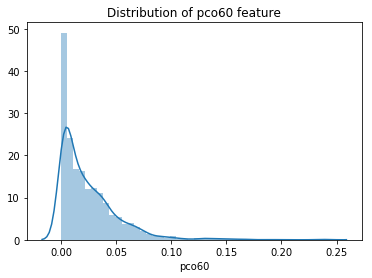

In [11]:
icu_beds.loc[:,'pco60']= icu_beds['popOver60perICU'] / icu_beds['Total Population']
icu_summary = icu_beds[['State','County','Total Population','num_icu_be', 'bed_utiliz', 'potential',
                        'pco60','popOver60','percentOver60','popOver60perICU']]
icu_merged = pd.merge(icu_summary,latest_cases,left_on=["County","State"],right_on=["county","state"])
sns.distplot(icu_beds.pco60.dropna()).set_title('Distribution of pco60 feature')

In [12]:
#derive some per capita stats
icu_merged.loc[:,'deaths_per_capita']= icu_merged['deaths'] / icu_merged['Total Population']
icu_merged.loc[:,'cases_per_capita']= icu_merged['cases'] / icu_merged['Total Population']
icu_merged.loc[:,'deaths_per_case'] = icu_merged['deaths'] / icu_merged['cases']

In [13]:
#save file
icu_merged[icu_merged['Total Population']>0].dropna().to_csv('../Generated_Files/nyt_enriched.csv',index=False)

### Data Exploration

In [14]:
#sample counties with at least one death
sample = icu_merged[icu_merged.deaths_per_capita>0]
sample.describe()

,Total Population,num_icu_be,bed_utiliz,potential,pco60,popOver60,percentOver60,popOver60perICU,fips,cases,deaths,days_since_first_case,deaths_per_capita,cases_per_capita,deaths_per_case
count,1.139000e+03,1139.000000,1139.000000,1139.000000,1123.000000,1.139000e+03,1139.000000,1123.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000,1139.000000
mean,2.308859e+05,50.562774,1.160497,82.145742,0.020566,4.710878e+04,22.570149,1310.713268,28994.064969,1523.606673,77.427568,89.882353,0.000234,0.005323,0.046810
std,5.016469e+05,110.865164,2.108612,201.488834,0.023819,9.279692e+04,4.844638,925.229997,15167.617962,4852.021798,270.117589,9.234222,0.000316,0.006072,0.038314
min,1.023900e+04,1.000000,0.060959,-444.000000,0.000084,2.329000e+03,10.300000,137.000000,1001.000000,5.000000,1.000000,47.000000,0.000004,0.000145,0.000920
25%,4.451100e+04,8.000000,0.368689,0.000000,0.003829,1.034900e+04,19.450000,706.500000,17178.000000,108.500000,3.000000,84.000000,0.000044,0.001719,0.018679
50%,9.144200e+04,17.000000,0.579493,27.000000,0.012243,2.009900e+04,22.300000,1081.000000,28075.000000,332.000000,10.000000,89.000000,0.000106,0.003429,0.036122
75%,2.123830e+05,47.000000,1.190126,80.000000,0.029684,4.581400e+04,24.900000,1639.500000,42006.000000,969.000000,40.000000,95.000000,0.000296,0.006398,0.066064
max,1.010572e+07,2004.000000,44.525842,2822.000000,0.241792,1.800341e+06,64.200000,8469.000000,56039.000000,85858.000000,4304.000000,148.000000,0.002193,0.054735,0.285714


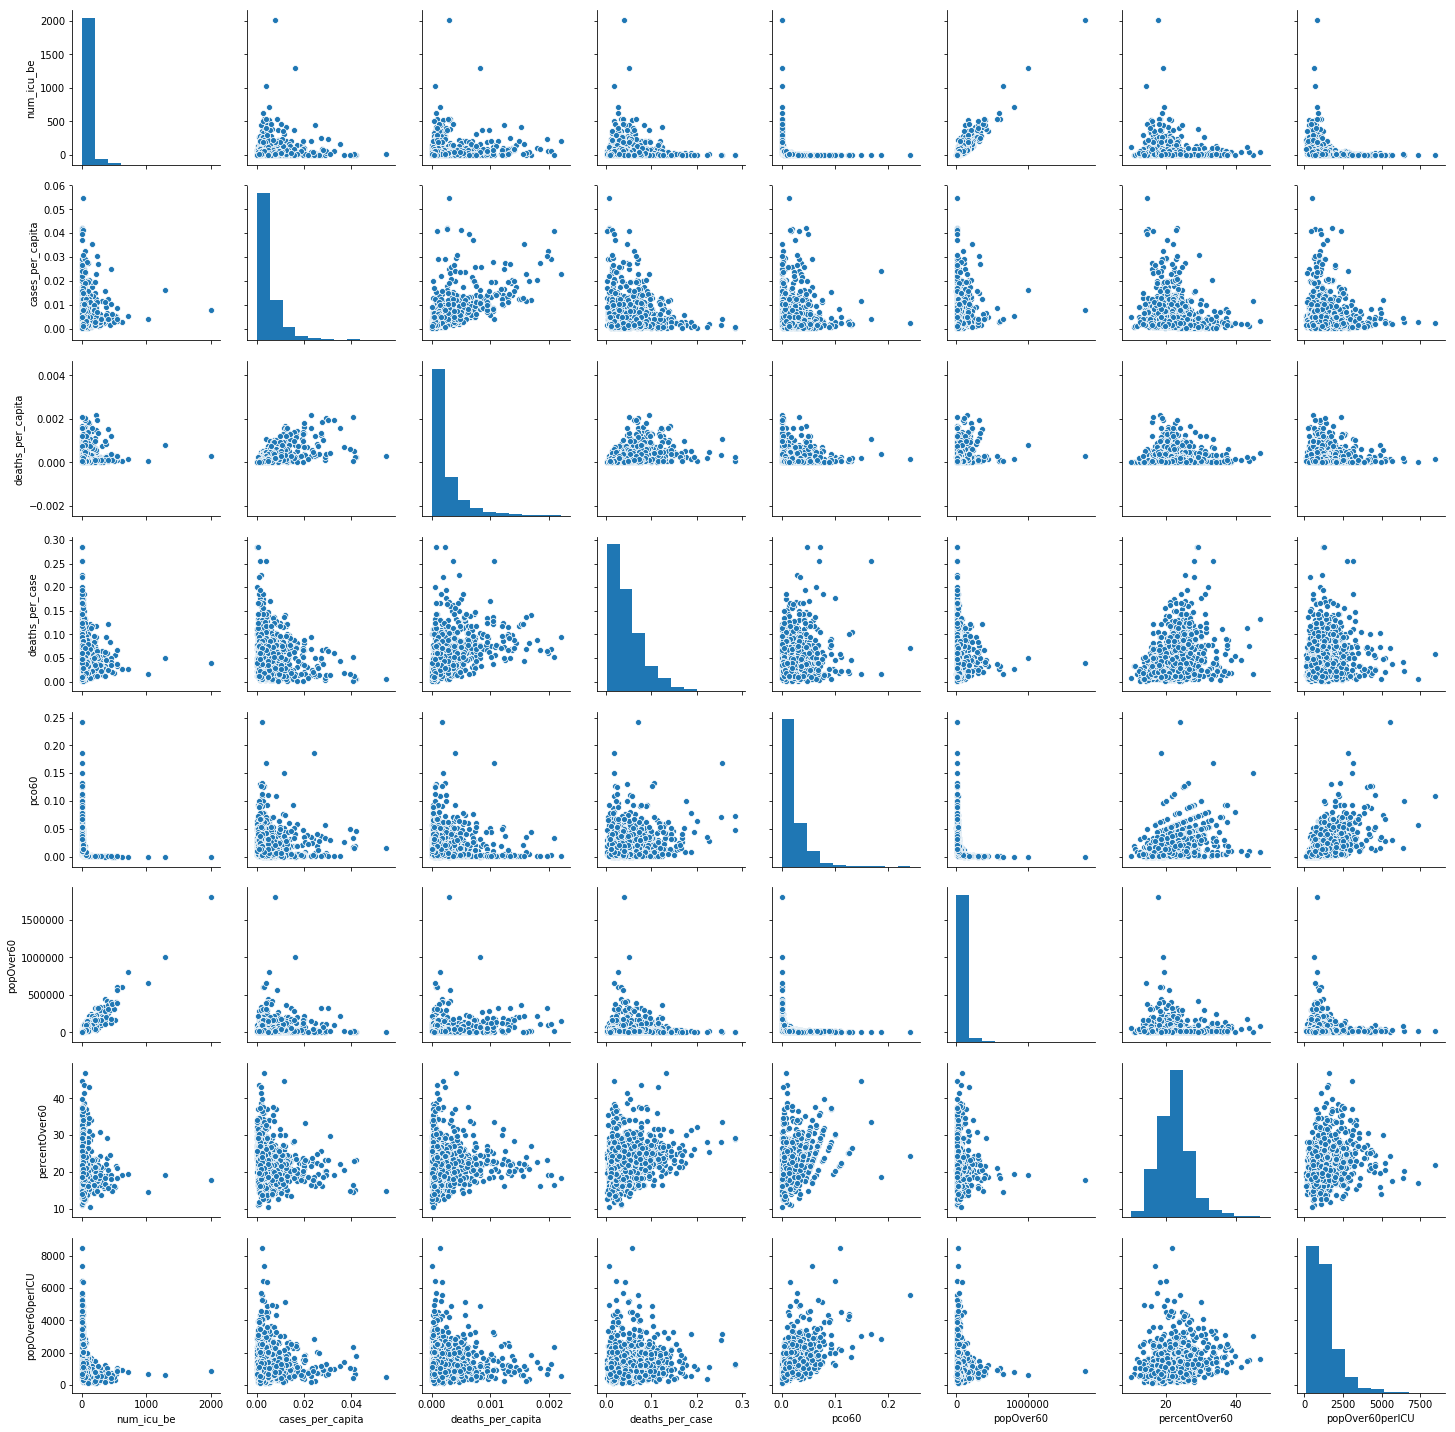

In [15]:
sns.pairplot(sample[['num_icu_be',
                     #'bed_utiliz',
                     #'potential',
                     'cases_per_capita',
                     'deaths_per_capita',
                     'deaths_per_case',
                     'pco60',
                     'popOver60',
                     'percentOver60',
                     'popOver60perICU']].dropna())

Text(0.5,1,'County per capita 60+ per ICU bed vs per capita deaths\n NYT enriched data as of April 27')

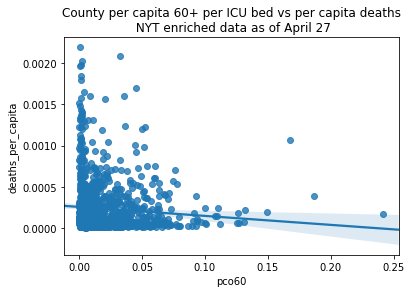

In [16]:
sns.regplot('pco60','deaths_per_capita',data=sample).set_title("County per capita 60+ per ICU bed vs per capita deaths\n NYT enriched data as of April 27")

Text(0.5,1,'County raw pop 60+ vs per capita deaths\n NYT enriched data as of April 27')

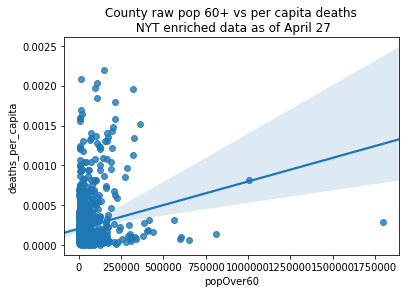

In [17]:
sns.regplot('popOver60','deaths_per_capita',data=sample).set_title("County raw pop 60+ vs per capita deaths\n NYT enriched data as of April 27")

One explanation for the smaller pco60 for higher deaths per capita is that we aren't far enough into the curve.

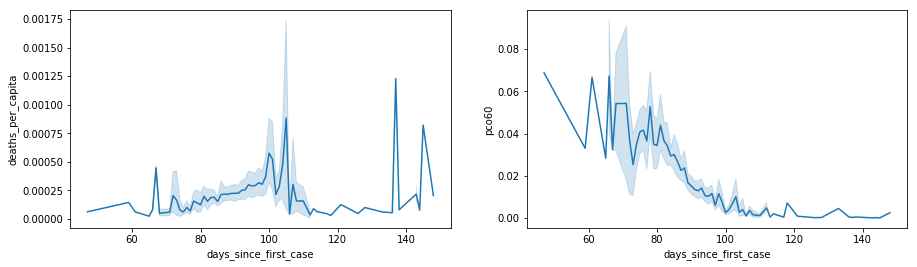

In [18]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(15,4))

sns.lineplot(sample['days_since_first_case'],sample['deaths_per_capita'],ax=ax1)
sns.lineplot(sample['days_since_first_case'],sample['pco60'],ax=ax2)

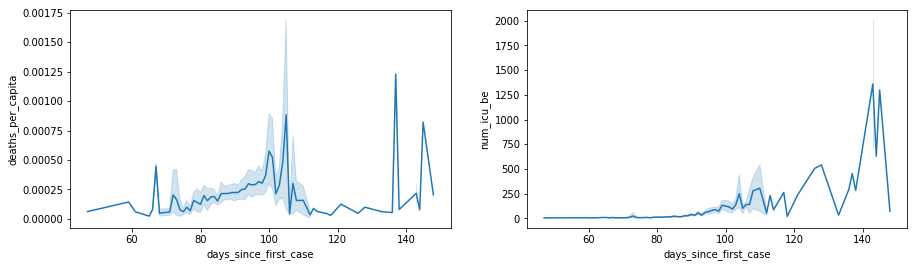

In [19]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(15,4))

sns.lineplot(sample['days_since_first_case'],sample['deaths_per_capita'],ax=ax1)
sns.lineplot(sample['days_since_first_case'],sample['num_icu_be'],ax=ax2)

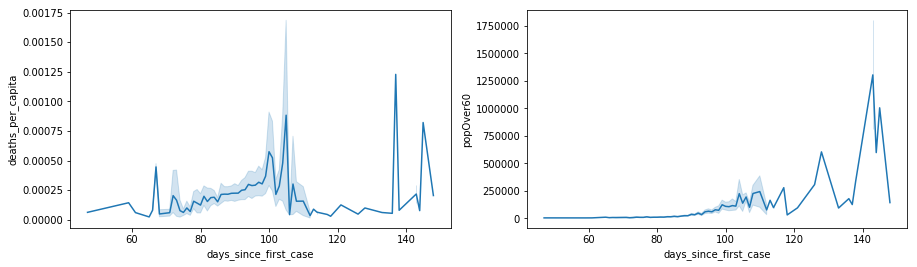

In [20]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(15,4))

sns.lineplot(sample['days_since_first_case'],sample['deaths_per_capita'],ax=ax1)
sns.lineplot(sample['days_since_first_case'],sample['popOver60'],ax=ax2)

The highest pco60 counties are 20-60 days since first case, but the highest death per capita occurs in counties closer to 110 and 140 days in

In [21]:
sample[sample['days_since_first_case']>80].sort_values(by='deaths_per_capita',ascending=False)

,State,County,Total Population,num_icu_be,bed_utiliz,potential,pco60,popOver60,percentOver60,popOver60perICU,date,county,state,fips,cases,deaths,days_since_first_case,deaths_per_capita,cases_per_capita,deaths_per_case
766,New Jersey,Essex,800401,215.0,4.537763,1066,0.000687,146732,18.3,550.0,2020-06-17,Essex,New Jersey,34013.0,18421,1755,97,0.002193,0.023015,0.095272
792,New Mexico,McKinley,72849,5.0,0.675636,42,0.032739,11923,16.4,2385.0,2020-06-17,McKinley,New Mexico,35031.0,2968,152,89,0.002087,0.040742,0.051213
779,New Jersey,Union,557320,55.0,1.161934,258,0.002383,106249,19.1,1328.0,2020-06-17,Union,New Jersey,34039.0,16315,1131,100,0.002029,0.029274,0.069323
775,New Jersey,Passaic,510563,53.0,1.302724,124,0.001984,98279,19.2,1013.0,2020-06-17,Passaic,New Jersey,34031.0,16683,1007,101,0.001972,0.032676,0.060361
818,New York,Nassau,1363069,235.0,6.128906,1076,0.000506,318040,23.3,690.0,2020-06-17,Nassau,New York,36059.0,41320,2677,104,0.001964,0.030314,0.064787
768,New Jersey,Hudson,679756,89.0,3.059482,675,0.001540,109974,16.2,1047.0,2020-06-17,Hudson,New Jersey,34017.0,18755,1257,100,0.001849,0.027591,0.067022
761,New Jersey,Bergen,937920,112.0,3.885920,940,0.001535,211672,22.6,1440.0,2020-06-17,Bergen,New Jersey,34003.0,18928,1681,105,0.001792,0.020181,0.088810
41,Alabama,Tallapoosa,40756,6.0,0.460461,47,0.045000,11006,27.0,1834.0,2020-06-17,Tallapoosa,Alabama,1123.0,489,69,86,0.001693,0.011998,0.141104
236,Georgia,Dougherty,91522,50.0,0.599089,282,0.004152,18997,20.8,380.0,2020-06-17,Dougherty,Georgia,13095.0,1845,151,94,0.001650,0.020159,0.081843
269,Georgia,Upson,26241,28.0,0.372288,28,0.008574,6294,24.0,225.0,2020-06-17,Upson,Georgia,13293.0,308,42,82,0.001601,0.011737,0.136364
